In [ ]:
# @ Annu Zhou azhou60@gatech.edu

In [1]:
!pip install wordcloud

In [2]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


 
import re
import json
import os
from collections import Counter
import datetime as dt


 
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook


 
import pickle

In [3]:
import sys
print(sys.executable)

C:\anaconda3\envs\gnn_inter\python.exe


## Some Initializations on the CLAWs dataset


In [23]:
data_dir = 'kaggle-covid-en-tweets-april_classified_claws.tar\subset'
tweets = []
for file in sorted(os.listdir(data_dir)):
    tweets.append(pd.read_csv(data_dir + '/' + file, lineterminator = '\n'))

df = pd.concat(tweets)
df.tail()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,followers_count,friends_count,account_lang,account_created_at,verified,lang,Hate Probability,Counterhate Probability,Neutral Probability,Label
442016,1245863583411400710,912319950559354880,2020-04-02T23:59:59Z,DriveLockGlobal,"Last year, #ransomware attacks in the US made ...",HubSpot,NaN,NaN,NaN,False,...,365,1337,NaN,2017-09-25T14:16:41Z,False,en,0.013955,0.026112,0.996893,Neutral
442017,1245863582367019008,844242854,2020-04-02T23:59:59Z,Kserasera3,All the decades and decades of military buildi...,Twitter for iPhone,NaN,NaN,NaN,False,...,10479,10838,NaN,2012-09-24T20:21:41Z,False,en,0.020773,0.478250,0.810121,Neutral
442018,1245863580857032704,129505145,2020-04-02T23:59:59Z,GageNHV,Today's #COVID19 numbers from @GovNedLamont. T...,Twitter Web App,NaN,NaN,NaN,False,...,347,239,NaN,2010-04-04T14:22:30Z,False,en,0.002495,0.048329,0.754780,Neutral
442019,1245863579527417857,1646067066,2020-04-02T23:59:59Z,marykkeown,I'm deeply saddened to hear #Sudbury has its f...,Twitter Web App,NaN,NaN,NaN,False,...,1120,600,NaN,2013-08-04T20:41:13Z,False,en,0.004784,0.037990,0.893284,Neutral
442020,1245863579686846464,1155961041697873920,2020-04-02T23:59:59Z,Wyld_Stallyns88,This is what happened because @GovRonDeSantis ...,Twitter Web App,NaN,NaN,NaN,False,...,4,79,NaN,2019-07-29T21:59:23Z,False,en,0.000485,0.020540,0.985795,Neutral


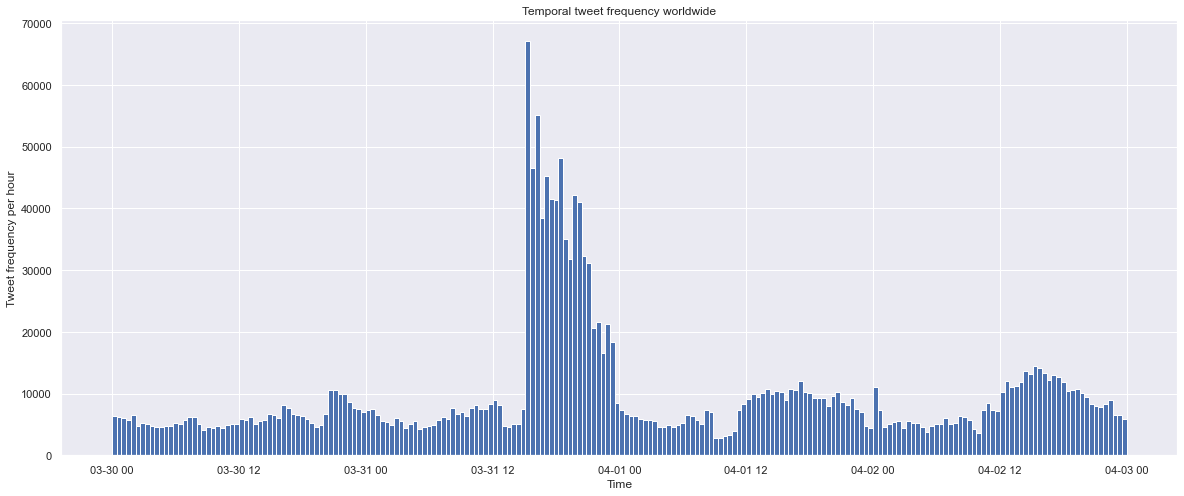

In [24]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency worldwide', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(pd.to_datetime(df.created_at), bins = 24*9, color = 'b')
plt.show()

In [26]:
text_en = df['text']
# text_en = df['Text']
text_en_lr = text_en.apply(lambda x: re.sub(r"https\S+", "", str(x)))
text_en_lr.head()

0    #DidYouKnow: @WFP is 100% voluntarily funded: ...
1    To treat COVID-19, administration expected to ...
2    To treat COVID-19, administration expected to ...
3    @MichiganDOT will not accept cash transactions...
4    @MichiganDOT will not accept cash transactions...
Name: text, dtype: object

In [27]:
text_en_lr_lc = text_en_lr.apply(lambda x: x.lower())
text_en_lr_lc.head()

0    #didyouknow: @wfp is 100% voluntarily funded: ...
1    to treat covid-19, administration expected to ...
2    to treat covid-19, administration expected to ...
3    @michigandot will not accept cash transactions...
4    @michigandot will not accept cash transactions...
Name: text, dtype: object

In [28]:
text_en_lr_lc_pr = text_en_lr_lc.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
text_en_lr_lc_pr.head()

0    didyouknow wfp is 100 voluntarily funded every...
1    to treat covid19 administration expected to re...
2    to treat covid19 administration expected to re...
3    michigandot will not accept cash transactions ...
4    michigandot will not accept cash transactions ...
Name: text, dtype: object

In [29]:
stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19'])

text_en_lr_lc_pr_sr = text_en_lr_lc_pr.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
text_en_lr_lc_pr_sr.head()

0    didyouknow wfp 100 voluntarily funded every ai...
1    treat administration expected relax physician ...
2    treat administration expected relax physician ...
3    michigandot accept cash transactions eastbound...
4    michigandot accept cash transactions eastbound...
Name: text, dtype: object

In [30]:
word_list = [word for line in text_en_lr_lc_pr_sr for word in line.split()]
word_list[:5]

['didyouknow', 'wfp', '100', 'voluntarily', 'funded']

## Histgrams - Frequency

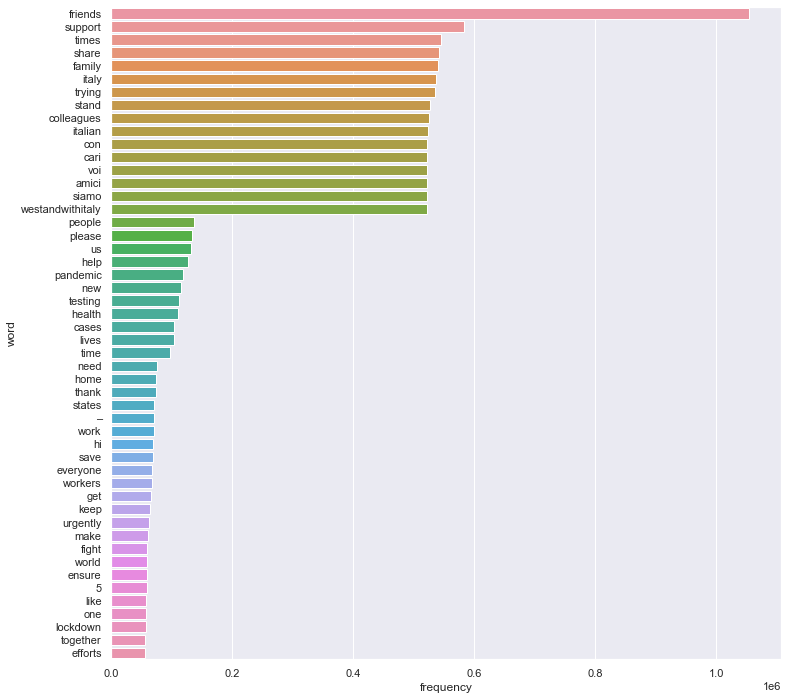

In [31]:
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)
plt.savefig('wordcount_bar.png')
plt.show()

## Wordcloud Visulization

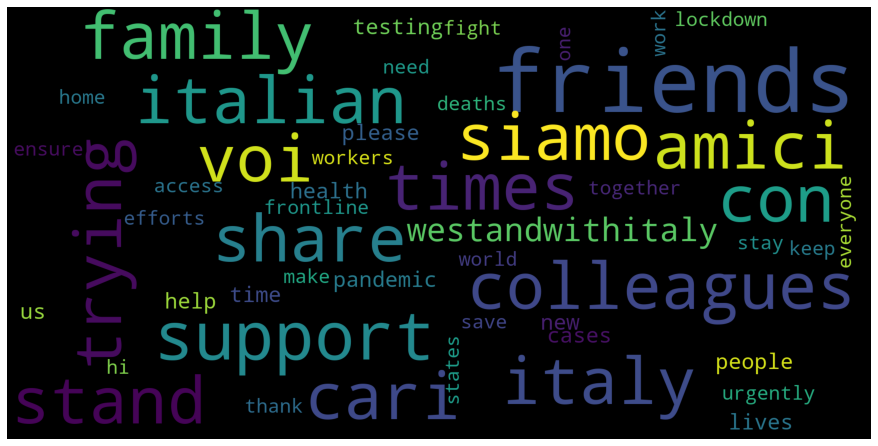

In [33]:
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(word_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('wordcloud.png')

## Sentiment Analysis

In [34]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = text_en_lr_lc_pr_sr.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores))
sent_scores_df.tail()

,neg,neu,pos,compound
2081035,0.228,0.658,0.114,-0.3818
2081036,0.000,1.000,0.000,0.0000
2081037,0.000,0.756,0.244,0.4404
2081038,0.369,0.631,0.000,-0.8221
2081039,0.000,1.000,0.000,0.0000


In [35]:
sent_scores_df['val'] = sent_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sent_scores_df.head()

,neg,neu,pos,compound,val
0,0.075,0.580,0.345,0.8519,positive
1,0.000,0.588,0.412,0.6808,positive
2,0.000,0.588,0.412,0.6808,positive
3,0.000,0.702,0.298,0.6249,positive
4,0.000,0.702,0.298,0.6249,positive


### Sentiment Analysis Plot

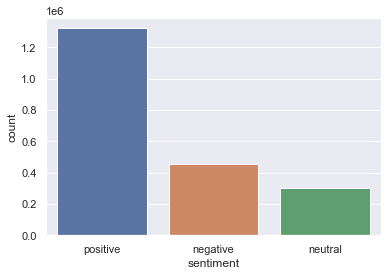

In [36]:
sent_counts = pd.DataFrame.from_dict(Counter(sent_scores_df['val']), orient = 'index').reset_index()
sent_counts.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_counts)
plt.savefig('sentiment.png')

## Comprehensive Wordcloud Plot

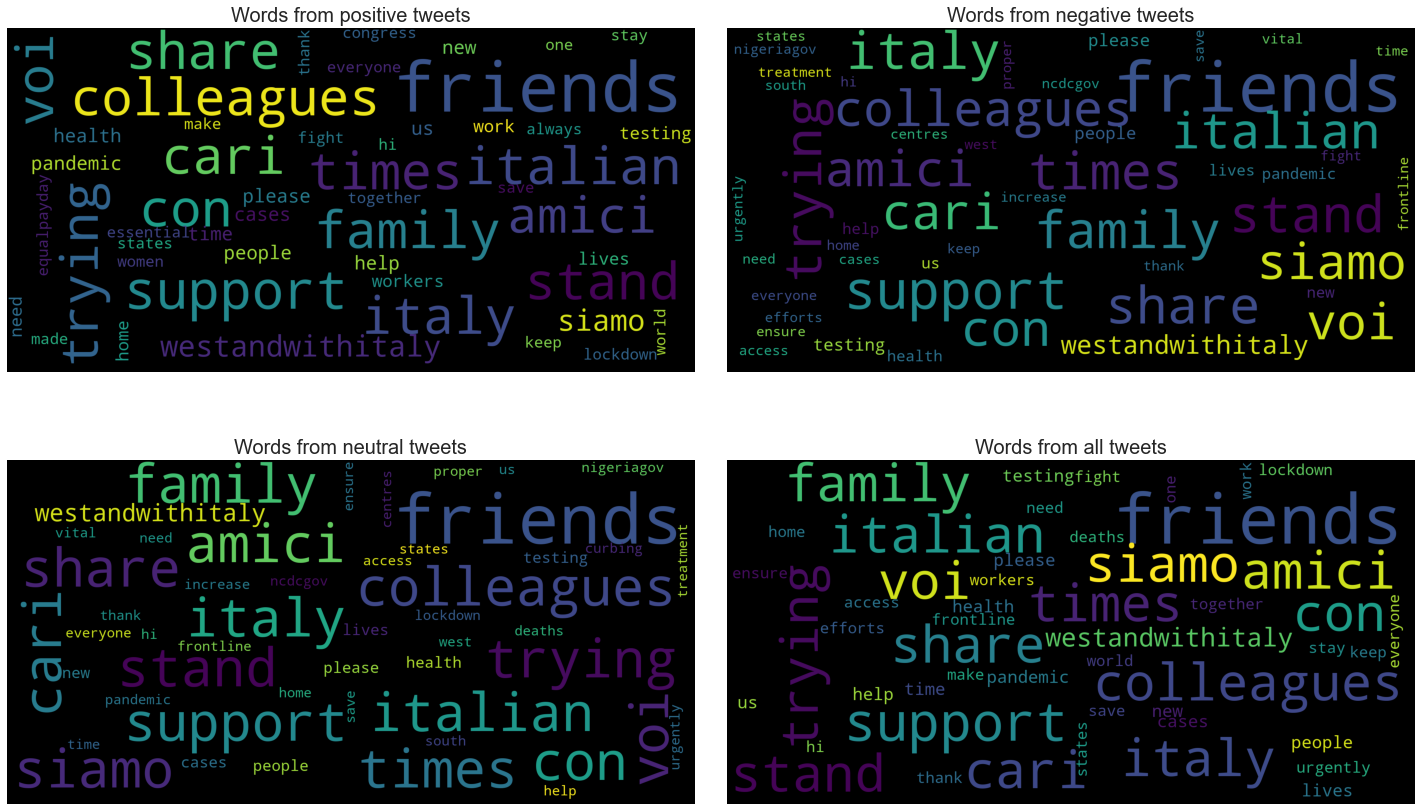

In [37]:
polar_tweets_df = pd.DataFrame()
polar_tweets_df['tweet'] = text_en_lr_lc_pr_sr
polar_tweets_df['polarity'] = sent_scores_df['val']

positive = polar_tweets_df[polar_tweets_df['polarity'] == 'positive']['tweet']
negative = polar_tweets_df[polar_tweets_df['polarity'] == 'negative']['tweet']
neutral = polar_tweets_df[polar_tweets_df['polarity'] == 'neutral']['tweet']

positive_list = [word for line in positive for word in line.split()]
negative_list = [word for line in negative for word in line.split()]
neutral_list = [word for line in neutral for word in line.split()]

positive_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(positive_list))

negative_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(negative_list))

neutral_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral_list))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))

fig.tight_layout(pad = 0)

axs[0, 0].imshow(positive_cloud)
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')


axs[0, 1].imshow(negative_cloud)
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')


axs[1, 0].imshow(neutral_cloud)
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')


axs[1, 1].imshow(wordcloud)
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')

plt.savefig('joint_cloud.png')